In [1]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from skimage import data
from skimage import img_as_float
from sklearn.cluster import KMeans

# Image Reconstruction by Matrix Completion

The aim of this notebook is to reconstruct a corrupted image by matrix completion using the **Singular Value Thresholding** (SVT) algorithm.<br>
Given an incomplete matrix **M**, our objective is to solve:<br><br>
$$ X^* = \arg\min_{X} \tau\|X|_* + \frac{1}{2} \|X\|_F^2\quad\text{subject to}\quad P_{\Omega}(X)=P_\Omega(M),$$
<br>where $\Omega$ represents the set of indices where the values of **M** are **known**. $P_{\Omega}$ is a projection operator that operates on a matrix to retain only the values at $\Omega$.

The SVT algorithm has the following update iterations:<br><br>
$$
\begin{split}
X^{(k+1)} &= D_\tau(Y^{(k)}),\\
Y^{(k+1)} &= Y^{(k)} + \beta P_\Omega(M-X^{(k+1)}).\end{split}
$$
The starting value is $Y^{(0)} = 0$.<br> 
The algorithm stops after $k$ steps if:<br><br>
$$ \frac{\|P_\Omega(M)-P_\Omega(X^{(k)})\|_F}{\|P_\Omega(M)\|_F} \le \text{tolerance}.$$


<br>The function **<font color='red'>matrix_complete</font>** below performs the SVT algorithm and has the following input:
* **<font color='red'>M</font>** - the incomplete matrix in $\mathbb{R}^{D\times N}$. The **known** values are assumed to be between 0 and 1, and an unknown value will be marked by **<font color='red'>-1</font>**.
* **<font color='red'>tolerance</font>** - the maximum tolerance to decide when iterations should stop. The default value is $8.1\times 10^{-5}$.
* **<font color='red'>beta_val</font>** - a value for the increment size $\beta$.<br>
The default value is $\beta = 0.82\times\frac{D\times N}{K}$, where **K** is the number of **known** entries in **M**.
* **<font color='red'>tau_val</font>** - a value for the shrinking size $\tau$. <br>
The default value is $\tau = 0.37\times\max(D,N)$.
* **<font color='red'>max_iter</font>** - maximum number of iterations to run.
* **<font color='red'>iter_print</font>** - how often to print out a progress line.

The output of the function is the completed matrix **<font color='red'>X</font>**.


In [2]:
# Loading the image from the skimage library.

image = data.astronaut()

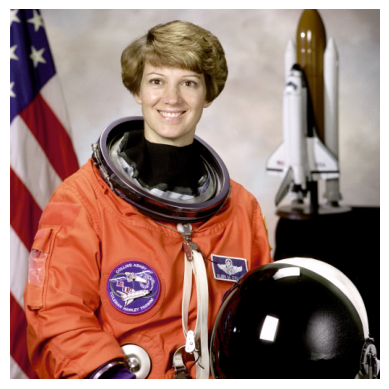

In [3]:
# Converting the image values to float, and presenting the image.

image = img_as_float(image)
plt.imshow(image)
plt.axis('off')
plt.tight_layout;

The functions **<font color='red'>shrink</font>** and **<font color='red'>svd_threshold</font>** are utilised by the **<font color='red'>matrix_complete</font>** to perform the SVT algorithm.

In [11]:
def shrink(X, tau):
    
    """This function takes a vector/matrix X, a scalar value tau, and shrinks the values in X based on 3 inequalities."""
    
    new_X = X.copy()
    
    x1 = np.where(X > tau) # Selects the indices in X where the values are greater than tau
    x2 = np.where(X < -tau) # Selects the indices in X where the values are less than tau
    x3 = np.where((X >= -tau) & (X <= tau)) # Selects the indices in X where the values are between -tau and tau
    
    new_X[x1] -= tau    # Adjusts the matrix values that satisfy the first inequality
    new_X[x2] += tau
    new_X[x3] = 0
    
    return new_X

def svd_threshold(X, tau):
    
    """This function takes a matrix X and a scalar value tau, applies Singular Value Decomposition to the matrix X, and
    then reconstructs X based on its singular values shrunk by tau."""
    
    U,S,Vt = np.linalg.svd(X, full_matrices=False)
    
    return U@np.diag(shrink(S, tau))@Vt

In [12]:
def matrix_complete(M, tolerance=8.1e-5, beta_val=None, tau_val=None, max_iter=10000, iter_print=100):
    
    """This function takes an incomplete matrix M and returns a low-rank approximation of it that retains as much of the
    known information in the original matrix M as possible."""
    
    shape = M.shape # Finds the dimensions of M
    K = np.sum(M != -1) # Finds the number of known entries in M
    omega = np.where(M != -1) # Selects the indices of the known entries in M
    
    if (beta_val == None):
        beta_val = 0.82 * np.prod(shape) / K
    
    if (tau_val == None):
        tau_val = 0.37 * np.max(shape)
    
    # Initially the counter and error are set to zero and infinity respectively
    counter = 0
    error = np.Inf
    
    Yk = np.zeros(shape)
    
    while (error > tolerance) and (counter < max_iter):
    
    # Keep iterating as long as the error is above the tolerance, or the maximum number of iterations has not been reached
        
        Xk = svd_threshold(Yk, tau_val)
        Yk[omega] = Yk[omega] + beta_val * (M - Xk)[omega]
        
        error = np.linalg.norm(M[omega]-Xk[omega])/ np.linalg.norm(M[omega])
        counter += 1
        
        if ((counter % iter_print) == 0):
            print('iteration: {}, error: {:0.10f}'.format(counter, error)) # Printing a progress line
    
    print('DONE. error: {:0.10f}'.format(error)) # Print the final error when the algorithm is done
    
    X = Xk

    return X

The function **<font color='red'>matrix_corrupt</font>** takes a matrix **X**, assumed to have positive values, and with probability **P** replaces each element with a value of **<font color='red'>-1</font>** to mark it as a **missing value**.

In [13]:
def matrix_corrupt(X, P):
    Xnew = np.array(X)
    R = np.random.rand(X.shape[0], X.shape[1])
    IDX = np.where(R<P)
    Xnew[IDX] = -1
    return Xnew

We will use the matrix completion algorithm to correct missing values in the RGB image. The missing values can appear in any of the R/G/B channels independently.<br><br> Therefore, if the image is of width  **W** and height **H**, we will process it as a matrix with **H rows** and **3W columns**.<br>
We start by writing two functions to convert between the two formats:
* **<font color=red>im2mat</font>** - converts an image from an **(H x W x 3)** 3d-array to an **(H x 3W)** matrix.
* **<font color=red>mat2im</font>** - converts an **(H x 3W)** matrix back into an **(H x W x 3)** 3d-array.

In [15]:
def im2mat(image):
    
    """Takes an image array with shape (H, W, 3) and returns a matrix with shape (H, 3*W)"""
    
    a, b, c = image.shape # Stores the dimensions of the image array in three variables
    matrix = image.transpose(0, 2, 1).reshape(a, b * c) # Converts the 3D-array to a matrix
    
    return matrix

def mat2im(mat):
    
    """Takes a matrix with shape (H, 3*W) and returns an array with shape (H, W, 3)"""
    
    a = mat.shape[0] # Stores the first dimension of the new array
    b = mat.shape[1]//3 # Stores the second dimension of the new array
    
    three_dimensional_array = mat.reshape(a, 3, b).transpose(0, 2, 1)
    
    return three_dimensional_array

Next, we convert the photo stored in **image** to a matrix using **im2mat**. The result is saved in **<font color=red>im_mat</font>**.

In [16]:
im_mat = im2mat(image)

Now we will erase random values from the matrix using the function **matrix_corrupt** to simulate missing values.<br>The result is saved in **<font color=red>im_mat_cor</font>**. 

In addition, since we will want to show what the corrupt image looks like, we will convert the matrix version back to an RGB format and store it in **<font color=red>im_cor</font>**.

In [17]:
im_mat_cor = matrix_corrupt(im_mat, 0.3)
im_cor = np.clip(mat2im(im_mat_cor), 0, 1)

The next step is to complete the missing value in the matrix **im_mat_cor**. To do that, we use the function **matrix_complete**. The result is stored in **<font color=red>im_mat_comp</font>**.

After the matrix completion is done, the matrix is converted back into an image and stored in **<font color=red>im_comp</font>**. 

In [18]:
im_mat_comp = matrix_complete(im_mat_cor, tolerance=8.1e-5, beta_val=1.23, tau_val=97, max_iter=50, iter_print=100)

im_comp = np.clip(mat2im(im_mat_comp),0,1)

DONE. error: 0.0321655822


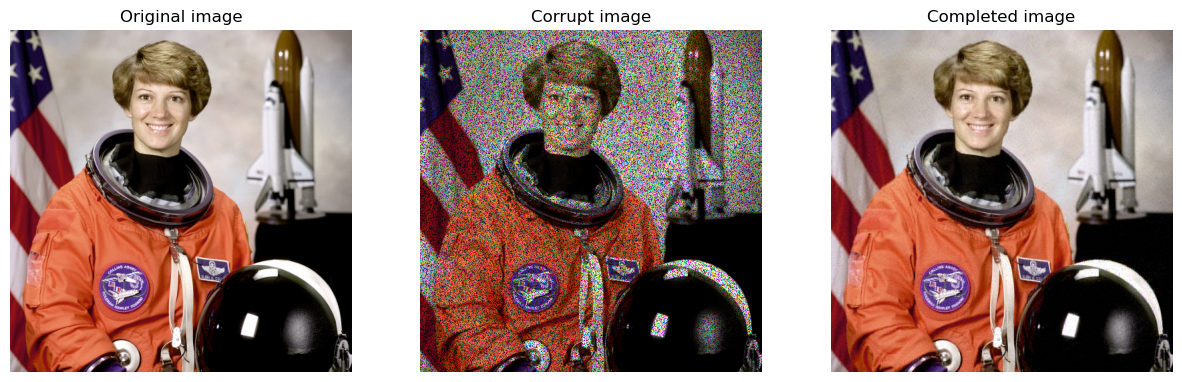

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.title('Original image')

plt.subplot(1,3,2)
plt.imshow(im_cor);
plt.axis('off');
plt.title('Corrupt image')

plt.subplot(1,3,3)
plt.imshow(im_comp)
plt.title('Completed image')
plt.axis('off');

Now we will repeat the experiment above but with different values for the parameters **tolerance**, $\beta$ and $\tau$ to test their effects.

In [20]:
im_mat_cor = matrix_corrupt(im_mat, 0.3)
im_cor = np.clip(mat2im(im_mat_cor), 0, 1)

im_mat_comp = matrix_complete(im_mat_cor, tolerance=8.1e-5, beta_val=1.23, tau_val=97e1, max_iter=50, iter_print=100)
im_comp = np.clip(mat2im(im_mat_comp),0,1)

DONE. error: 0.1731978583


Increasing $\tau$ by a factor of 10 gives a poorer completed image because it sets more singular values to zero, which reduces the rank of the matrix at the cost of losing more of the original information.

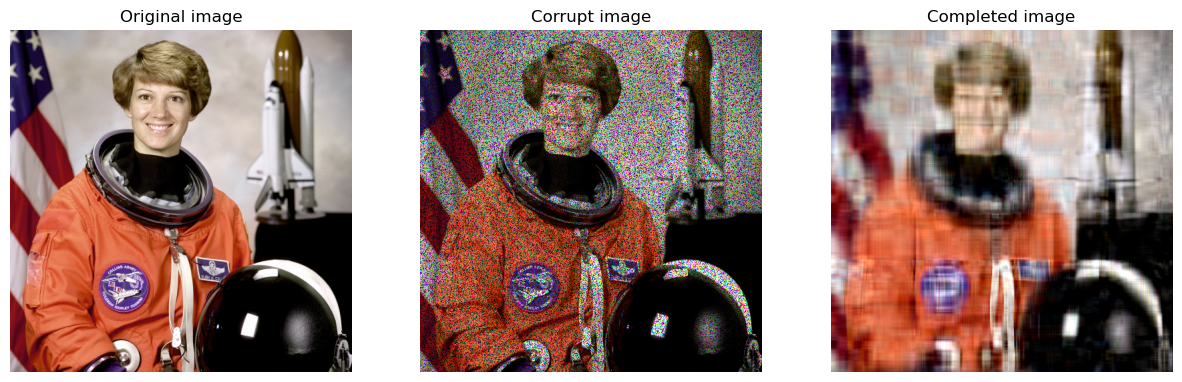

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.title('Original image')

plt.subplot(1,3,2)
plt.imshow(im_cor);
plt.axis('off');
plt.title('Corrupt image')

plt.subplot(1,3,3)
plt.imshow(im_comp)
plt.title('Completed image')
plt.axis('off');

In [22]:
im_mat_cor = matrix_corrupt(im_mat, 0.3)
im_cor = np.clip(mat2im(im_mat_cor), 0, 1)

im_mat_comp = matrix_complete(im_mat_cor, tolerance=8.1e-2, beta_val=1.23, tau_val=97, max_iter=50, iter_print=100)
im_comp = np.clip(mat2im(im_mat_comp),0,1)

DONE. error: 0.0784064549


Increasing the tolerance by a factor of 1000 gives a poorer completed image due to less preservation of the original information.

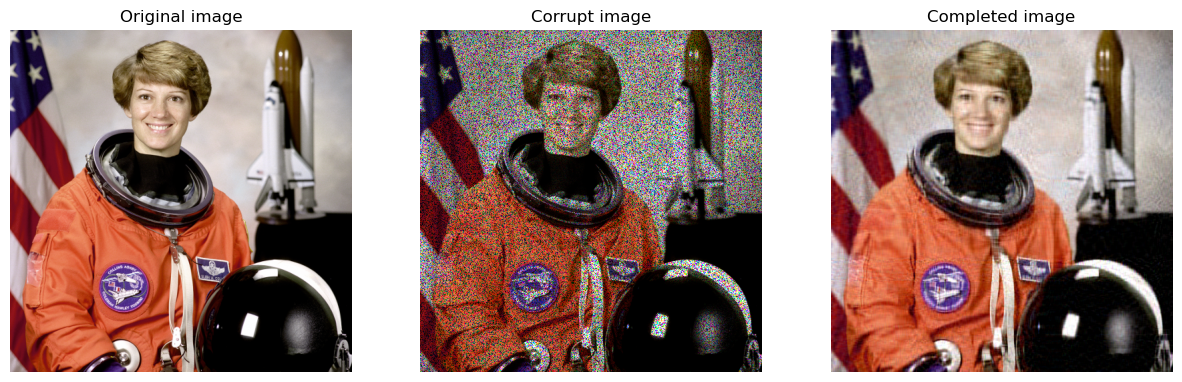

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.title('Original image')

plt.subplot(1,3,2)
plt.imshow(im_cor);
plt.axis('off');
plt.title('Corrupt image')

plt.subplot(1,3,3)
plt.imshow(im_comp)
plt.title('Completed image')
plt.axis('off');

- The tolerance parameter determines the point at which the matrix completion algorithm terminates. Since the error depends on the difference between corrupted matrix and the completed matrix at the known indices, a smaller tolerance value means the completed matrix will retain more of the known values of the corrupted matrix, leading to a better image recovery. A higher tolerance speeds up the convergence as it relaxes the error threshold at which the algorithm terminates.
- The $\tau$ parameter determines the degree of shrinkage that is applied to the singular values of the completed matrix. A larger $\tau$ means more singular values will be set to zero which removes noise from the matrix but might lead to greater loss of the originally known information. A smaller $\tau$ means the completed matrix will be more similar to the original matrix which leads to smaller error, and therefore faster convergence.
- The $\beta$ parameter controls the step size of each iteration. A small $\beta$ reduces the step size which can reduce the error but at the cost of a slower convergence speed.